## Advanced Machine Learning Models
### Goal: Achieve strong performance
### Models
 - Random Forest
 - XGBoost
 - LightGBM (primary model)
 - CatBoost
### Techniques
 - Time-series cross-validation
 - Feature importance
 - Hyperparameter tuning (Optuna)
### Output: Best ML model


# Notebook Setup & Data Preparation

 - Load feature-engineered dataset
 - Memory optimization (critical for Colab)
 - Final NaN handling (lag-safe)
### Goal:
 - target (sales_log)
 - feature list
 - Time-based train/validation split

In [1]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

Cloning into 'Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 89 (delta 40), reused 25 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 21.64 MiB | 15.66 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Filtering content: 100% (11/11), 315.52 MiB | 24.22 MiB/s, done.
Encountered 1 file(s) that should have been pointers, but weren't:
	data/reports/baseline_results.csv


In [2]:
# Environment Setup - Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

import os
from pathlib import Path
import gc

In [3]:
# Set Project Root
os.chdir("/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform")
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [4]:
# Load Feature-Engineered Data
DATA_DIR = Path("data/features")

train = pd.read_parquet(DATA_DIR / "train_features.parquet")

In [5]:
# Memory Optimization (reduce memory usage)
def reduce_mem_usage(df, ):
  for col in df.columns:
    if df[col].dtype == "float64":
      df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
      df[col] = df[col].astype("int32")
  return df

train = reduce_mem_usage(train)
gc.collect()

0

In [6]:
# Data Handling and Sorting
train['date'] = pd.to_datetime(train['date'])
train = train.sort_values(
    ['store_nbr', 'family', 'date']
).reset_index(drop=True)

In [7]:
# Drop NaN values in Lag/Roll Features
# identify Lag/Roll Columns
lag_cols = [col for col in train.columns if "lag" in col or "roll" in col]

# Drop NaN
initial_rows = len(train)

train = train.dropna(subset=lag_cols)

print(f"Rows dropped: {initial_rows - len(train)}")
print(f"Remaining Rows: {len(train)}")
print(f"Loose Percentage: {100 * (initial_rows - len(train)) / initial_rows:.2f}")

Rows dropped: 49896
Remaining Rows: 3004452
Loose Percentage: 1.63


In [8]:
# Define Target and Features
TARGET = 'sales_log'
y = train[TARGET]

In [9]:
# Features Selection
# Drop unnecessaary Columns
Drop_cols = ['id', 'date', 'sales', 'sales_log']

FEATURES = [col for col in train.columns if col not in Drop_cols]

X = train[FEATURES]

In [10]:
# Categorical Features
CAT_COLS = train.select_dtypes(include='category').columns.tolist()
CAT_COLS

['family',
 'city',
 'state',
 'store_type',
 'holiday_type',
 'locale',
 'locale_name',
 'description']

In [11]:
# Time Based Train / Validation Split
TRAIN_END_DATE = pd.to_datetime('2017-07-15')

train_model = train.copy()
train_mask = train_model['date'] <= TRAIN_END_DATE
valid_mask = train_model['date'] > TRAIN_END_DATE

X_train = X[train_mask]
y_train = y[train_mask]

X_valid = X[valid_mask]
y_valid = y[valid_mask]

In [12]:
# Data Split Summary
train_valid = train_model[valid_mask].reset_index(drop=True)

print("DATA SPLIT SUMMARY:\n")
print(f"Train dates: {train_model[train_mask]['date'].min().date()} to {train_model[train_mask]['date'].max().date()}")
print(f"Validation dates: {train_model[valid_mask]['date'].min().date()} to {train_model[valid_mask]['date'].max().date()}")

print(f"\nTrain Shape: {X_train.shape}")
print(f"Validation Shape: {X_valid.shape}")

DATA SPLIT SUMMARY:

Train dates: 2013-01-29 to 2017-07-15
Validation dates: 2017-07-16 to 2017-08-15

Train Shape: (2949210, 58)
Validation Shape: (55242, 58)


In [13]:
# RMSLE Evaluation Function
def rmsle(y_true, y_pred):
  y_true = np.expm1(y_true)
  y_pred = np.expm1(y_pred)
  y_pred = np.maximum(y_pred, 0)
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

## 1. Random Forest Model
 - Captures non-linearity
 - Strong improvement over linear models
 - Gives feature importance intuition

In [15]:
# Handling Categorical Features
!pip install category_encoders
from category_encoders import TargetEncoder

te = TargetEncoder()
X_train_te = te.fit_transform(X_train, y_train)
X_valid_te = te.transform(X_valid)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 7.0 MB/s eta 0:00:00


In [16]:
# Define RF Model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

In [18]:
# Train RF Mdole
rf_model.fit(X_train_te, y_train)

RandomForestRegressor(max_depth=12, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=50, n_jobs=-1, random_state=42)

In [19]:
# Validation Prediction
rf_valid_pred = rf_model.predict(X_valid_te)
rf_rmsle = rmsle(y_valid, rf_valid_pred)
print(f"Random Forest RMSLE: {rf_rmsle:.4f}")

Random Forest RMSLE: 0.3985


In [20]:
# feature Importances
# Create Importance Dataframe
rf_importance = pd.DataFrame({
    'feature': X_train_te.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Sort by Importance
rf_importance = rf_importance.sort_values(by='importance', ascending=False)

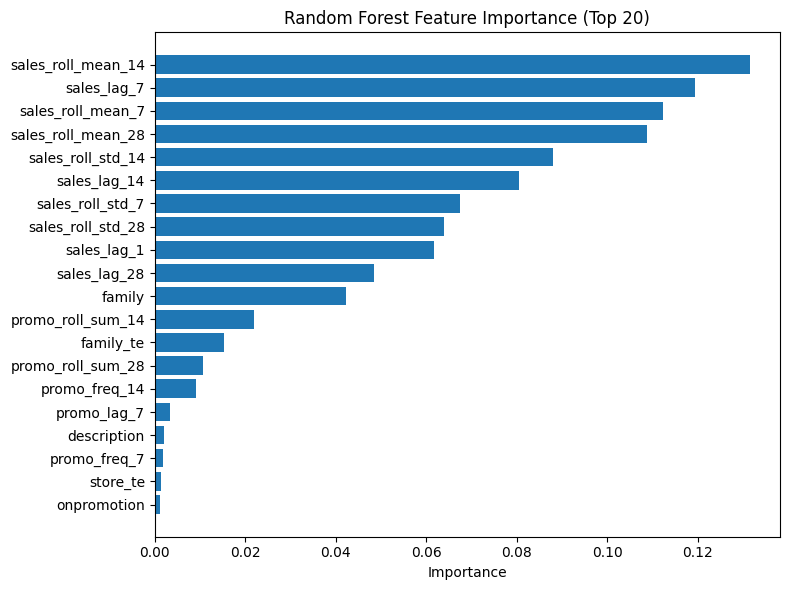

In [22]:
plt.figure(figsize=(8, 6))
plt.barh(
    rf_importance["feature"][:20][::-1],
    rf_importance["importance"][:20][::-1]
)
plt.title("Random Forest Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
